# Random Forests with IMDB

### Introduction

In this lesson we'll work with random forests on our imdb dataset.  Let's get started.

### Loading up our Data

In [1]:
import pandas as pd

df = pd.read_csv('./imdb_movies.csv')

In [25]:
X = df.loc[:, 'genre':'month']

In [40]:
y = df[['revenue']]

In [41]:
y.isna().any()

revenue    False
dtype: bool

In [27]:
X[:2]

,genre,budget,runtime,year,month
0,Action,237000000,162.0,2009,12
1,Adventure,300000000,169.0,2007,5


In [28]:
y[:2]

0    2787965087
1     961000000
Name: revenue, dtype: int64

### Coercing our Data

Let's use a `LabelEncoder` to change our `genre` feature.  The feature also has `na`, so it is important to first change them into the string `na`.

> * Otherwise, we will see the following error
> * TypeError: argument must be a string or number

In [29]:
from sklearn_pandas import DataFrameMapper
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer

mapper = DataFrameMapper([
    (['genre'], [SimpleImputer(strategy = 'constant', fill_value = 'na'), LabelEncoder()])
], df_out = True)

In [30]:
genre_transformed = mapper.fit_transform(X)

/Users/jeff/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Next replace our genre column in X with this data.

In [31]:
X.columns

Index(['genre', 'budget', 'runtime', 'year', 'month'], dtype='object')

In [32]:
X = X.assign(genre = genre_transformed)

In [33]:
X[:2]

,genre,budget,runtime,year,month
0,0,237000000,162.0,2009,12
1,1,300000000,169.0,2007,5


Next let's see if there are any other `isna` values to handle.

In [38]:
X.isna().any()

# genre      False
# budget     False
# runtime    False
# year       False
# month      False
# dtype: bool

genre      False
budget     False
runtime    False
year       False
month      False
dtype: bool

Ok, and one last look at our dtypes to ensure that everything is converted to a number.

In [39]:
X.dtypes

genre        int64
budget       int64
runtime    float64
year         int64
month        int64
dtype: object

Ok, we are set to split our data, and train our randomforest.

### Splitting our Data

Before we split our data into training, validation and test sets, we should order our data by the year and month of the movie release.  First order the X data by year and month.

In [153]:
X_selected = X[X['year'] > 2010]

In [154]:
X_sorted = X_selected.sort_values(['year', 'month'])

In [155]:
X_sorted[:3]

,genre,budget,runtime,year,month
252,0,120000000,119.0,2011,1
593,3,70000000,111.0,2011,1
1118,0,40000000,93.0,2011,1


Then we can use the indices of `X` to impose the same ordering on our series `y`.

In [156]:
y_sorted = y.loc[X_sorted.index]

In [157]:
y_sorted[:3]

252     227817248
593      67112664
1118     51070807
Name: revenue, dtype: int64

In [158]:
X_sorted.shape, y_sorted.shape

((506, 5), (506,))

Ok, now that we've ordered the data, let's split it into training, validation and test sets.

In [159]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_sorted, y_sorted, test_size = .2, shuffle = False)

In [160]:
X_validate, X_test, y_validate, y_test = train_test_split(X_test, y_test, test_size = .5, shuffle = False)

In [161]:
X_train.shape, X_validate.shape, X_test.shape

((404, 5), (51, 5), (51, 5))

Now let's train a random forest, and evaluate it on our validation set.

In [162]:
from sklearn.ensemble import RandomForestRegressor


model = RandomForestRegressor(n_estimators = 300)

model.fit(X_train,y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=300,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [163]:
model.score(X_train, y_train)

0.937996225960468

In [164]:
model.score(X_validate, y_validate)

0.3797276978724262

In [165]:
X_train[-1:]

,genre,budget,runtime,year,month
127,0,150000000,120.0,2015,5


### Changing the Year

In [167]:
# list(range(2000, 2016))

In [185]:
models = []
for year in range(2000, 2015):
    X_selected = X_train[X_train['year'] > year]
    y_selected = y_train[X_selected.index]
    model = RandomForestRegressor(n_estimators = 100).fit(X_selected, y_selected)
    models.append(model)

In [186]:
year_scores = [model.score(X_validate, y_validate) for model in models]

In [187]:
years_df = pd.DataFrame({'years': range(2000, 2015), 'scores': year_scores})

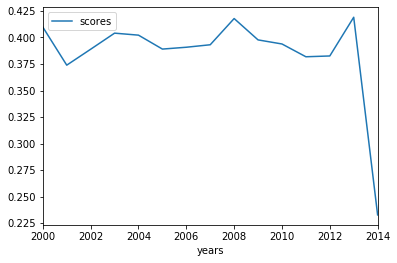

In [188]:
years_df.plot(x = 'years', y = 'scores')

In [190]:
years_df

,years,scores
0,2000,0.409797
1,2001,0.373910
2,2002,0.388927
3,2003,0.404099
4,2004,0.402216
5,2005,0.389076
6,2006,0.390811
7,2007,0.393149
8,2008,0.417879
9,2009,0.397738


It looks like our model peaks around 2008.

In [191]:
X_post_2006 = X_train[X_train['year'] > 2007]
y_post_2006 = y_train[X_post_2006.index]

### Hyperparameter tuning

In [192]:
depth_models = [RandomForestRegressor(max_depth = i,  n_estimators=100).fit(X_post_2006, y_post_2006) for i in range(1, 30)]

In [193]:
depth_scores = [model.score(X_validate, y_validate) for model in depth_models]

In [194]:
df = pd.DataFrame({'levels': list(range(1, 30)), 'scores': depth_scores})

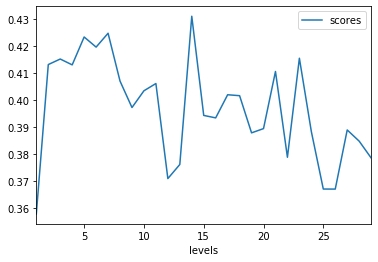

In [195]:
df.plot(x = 'levels', y = 'scores')

In [197]:
df[:9]

,levels,scores
0,1,0.357855
1,2,0.413073
2,3,0.415118
3,4,0.412959
4,5,0.423264
5,6,0.419525
6,7,0.424645
7,8,0.406963
8,9,0.397188


So it looks like we have hyperparameters that peak at around 5 levels.

In [200]:
model = RandomForestRegressor(max_depth = 5, n_estimators = 300)
model.fit(X_post_2006, y_post_2006) 

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=5,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=300,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [201]:
model.score(X_validate, y_validate)

0.44225787154171303

In [202]:
model.score(X_test, y_test)

0.4983288909060286

### Summary